# 🦥 Lazy-Snapping-Image-Cut-Out-Segmentation

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans

## 🖥️ The Algorithm

In [96]:
def kMeans(k, data):
    # Initialize centroids randomly by choosing k data points from the dataset
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]

    while True:
        # Assign each data point to the closest centroid
        labels = np.argmin(np.linalg.norm(data[:, None] - centroids, axis=2), axis=1)

        # Compute new centroids based on the mean of data points assigned to each cluster
        new_centroids = []
        for i in range(k):
            if len(data[labels == i]) == 0:
                # If a cluster has no assigned data points, keep the previous centroid unchanged
                new_centroids.append(centroids[i])
            else:
                # Compute the mean of data points assigned to the cluster as the new centroid
                new_centroids.append(data[labels == i].mean(axis=0))
        new_centroids = np.array(new_centroids)

        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids

    return centroids, labels

In [97]:
def rgbMaskToLabelMask(mask):
    # Create an empty label mask
    labelMask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.uint8)

    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):

            if np.all(mask[i, j] == np.array([255, 0, 0])):
                # If the pixel color is [255, 0, 0] (red), assign label 2
                labelMask[i, j] = 2

            elif np.all(mask[i, j] == np.array([6, 0, 255])):
                # If the pixel color is [6, 0, 255] (blue), assign label 0
                labelMask[i, j] = 0
            
            else:
                # For any other color, assign label 1
                labelMask[i, j] = 1

    return labelMask

def extractFeatures(img, mask):

    foregroundPixels = []
    backgroundPixels = []

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            
            if mask[i, j] == 2:
                # If the pixel belongs to the foreground (label 2), append it to the foreground pixels list
                foregroundPixels.append(img[i, j])
            
            elif mask[i, j] == 0:
                # If the pixel belongs to the background (label 0), append it to the background pixels list
                backgroundPixels.append(img[i, j])
    
    return np.array(foregroundPixels), np.array(backgroundPixels)

def eNegNorm(x, y):
    # Compute the Euclidean distance between vectors x and y using np.linalg.norm
    distance = np.linalg.norm(x - y)

    # Compute the negative exponential of the distance
    result = np.exp(-distance)

    return result

def prob(pixel, centroids, labels):
    # Calculate the exponential of the negative Euclidean distance between each centroid and the given pixel
    exps = eNegNorm(centroids, pixel)

    # Calculate the weights of each cluster based on the counts
    _, counts = np.unique(labels, return_counts=True)
    weights = counts / counts.sum()

    # Compute the weighted sum of the exponential distances
    result = (exps * weights).sum()
    return result


def showImage(img, figsize=(10,10), gray=True):
    plt.figure(figsize=figsize)
    if gray:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.axis('off')

In [ ]:
def segmentImage(img, seedMask, n=64):
    # Convert the seed mask to a label masks
    labelMask = rgbMaskToLabelMask(seedMask)

    # Extract foreground and background pixels from the image based on the label mask
    fgPixels, bgPixels = extractFeatures(img, labelMask)

    # Perform k-means clustering on the foreground and background pixels using n clusters
    fgCentroids, fgLabels = kMeans(n, fgPixels)
    bgCentroids, bgLabels = kMeans(n, bgPixels)

    # Create an empty segmented image
    segmentedImg = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):

            pixel = img[i, j]

            # Compute the probability of the pixel belonging to the foreground and background clusters
            fgProb = prob(pixel, fgCentroids, fgLabels)
            bgProb = prob(pixel, bgCentroids, bgLabels)

            # If the probability of the pixel belonging to the foreground is higher than the background,
            # assign a value of 255 (white) to the segmented image at the current position
            if fgProb > bgProb:
                segmentedImg[i, j] = 255

    return segmentedImg

## 🖼️ Test Case: Mona Lisa

### 🖌️ User Seed Segmentation 1

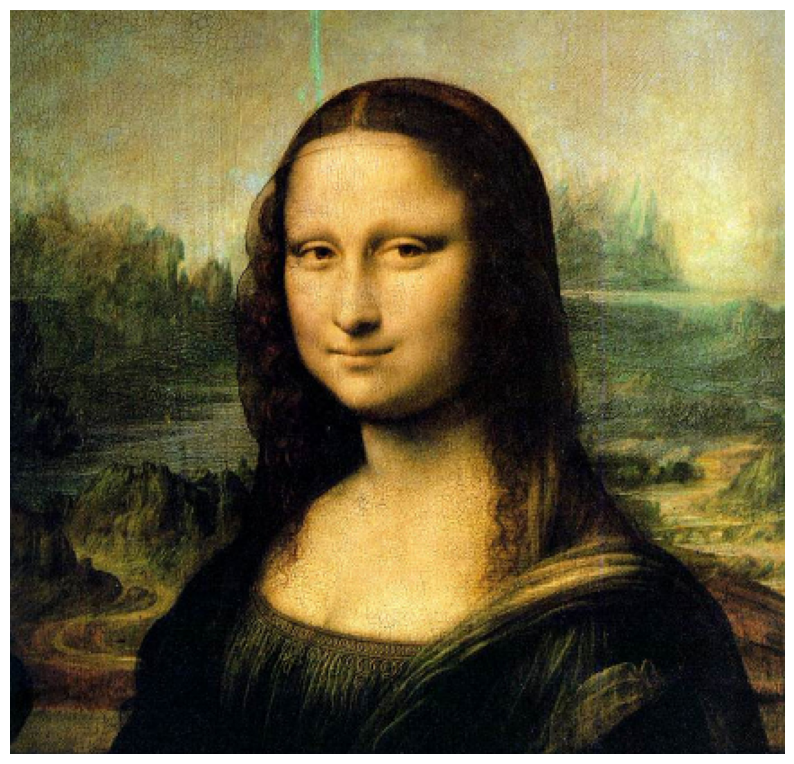

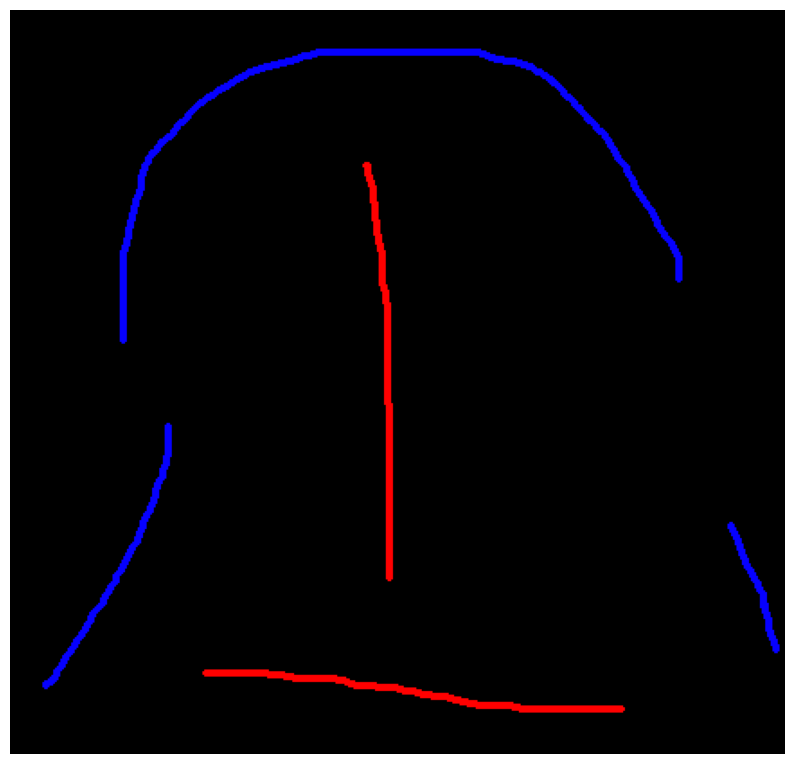

In [90]:
img = cv2.cvtColor(cv2.imread('./Mona-lisa.PNG', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
mask = cv2.cvtColor(cv2.imread('./Mona-lisa stroke 1.png', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
showImage(img, gray=False)
showImage(mask)

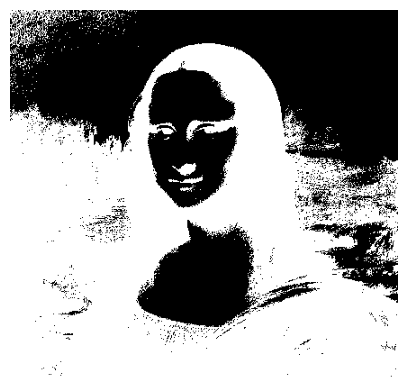

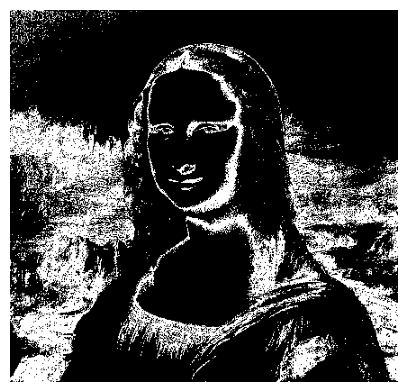

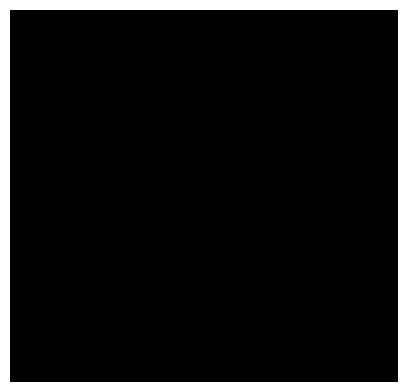

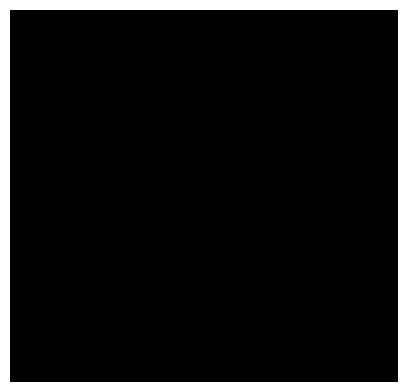

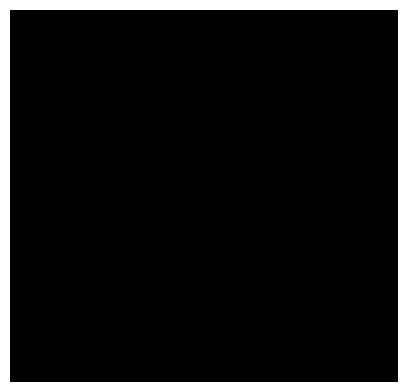

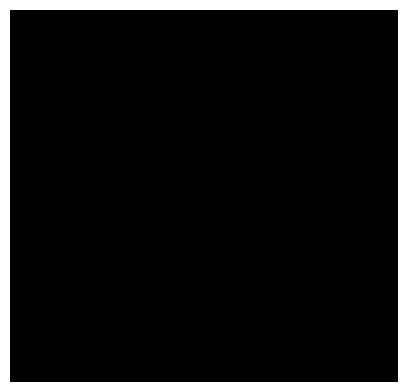

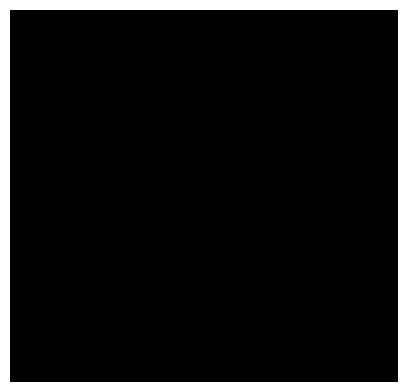

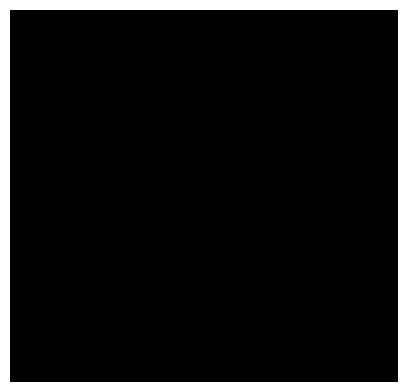

In [99]:
segmented = {}
for n in range(16, 129, 16):
    segmented[n] = segmentImage(img, mask, n)
    showImage(segmented[n], figsize=(5, 5))

### 🖌️ User Seed Segmentation 2

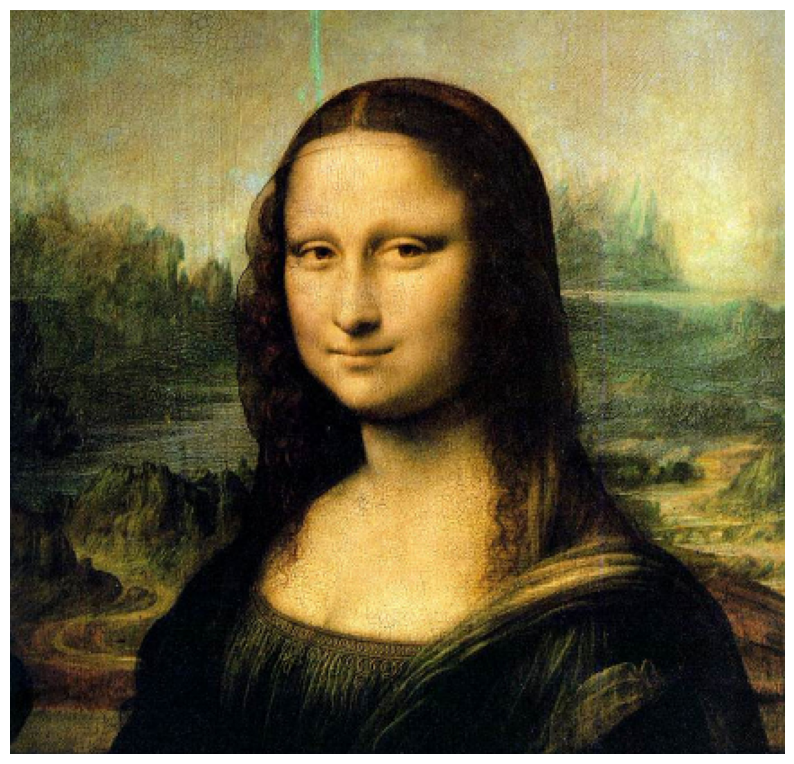

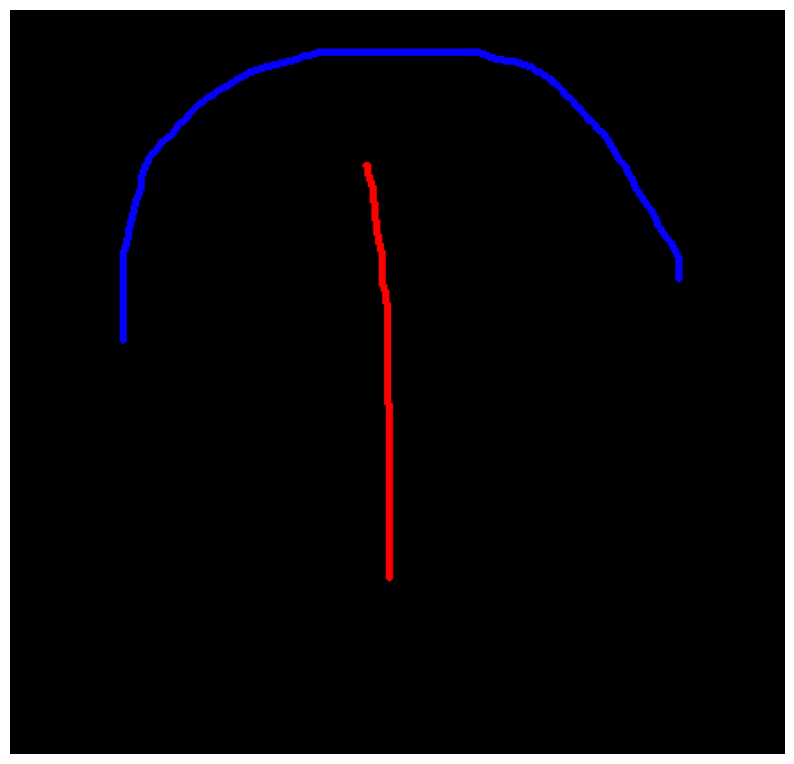

In [100]:
img = cv2.cvtColor(cv2.imread('./Mona-lisa.PNG', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
mask = cv2.cvtColor(cv2.imread('./Mona-lisa stroke 2.png', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
showImage(img, gray=False)
showImage(mask)

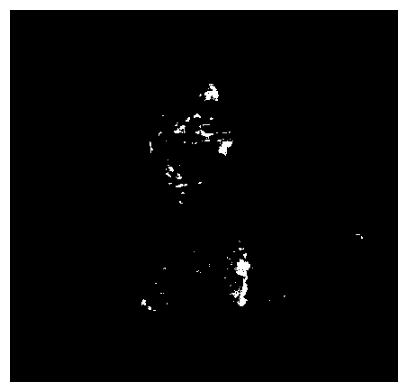

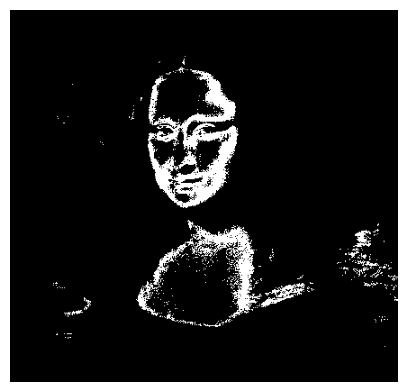

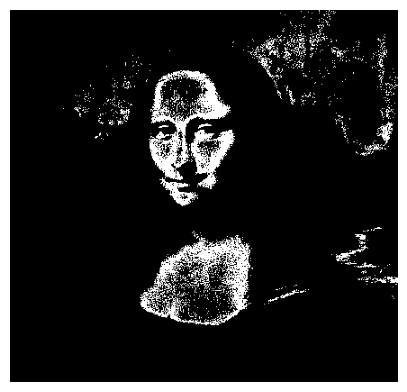

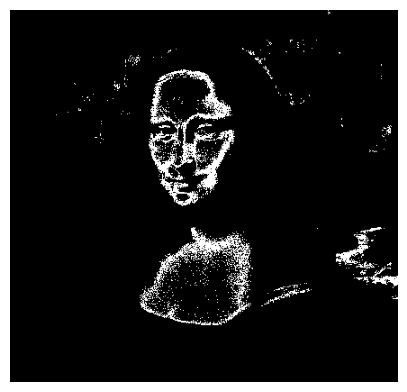

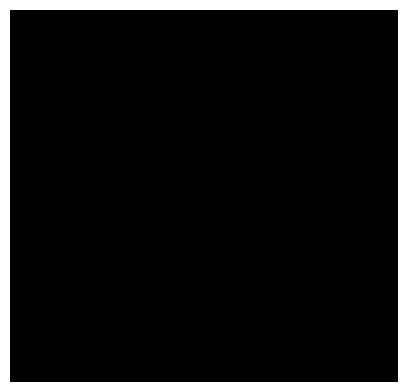

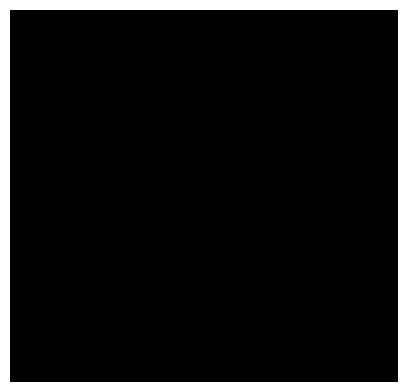

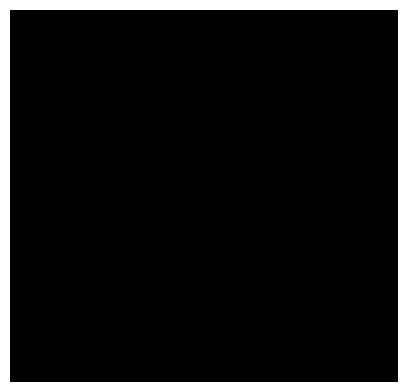

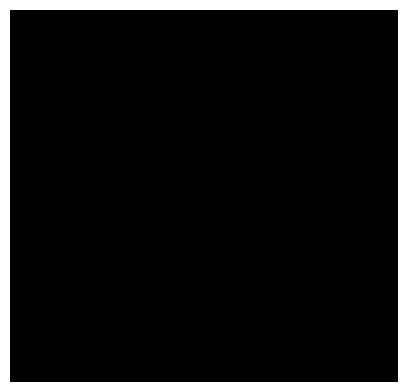

In [101]:
segmented = {}
for n in range(16, 129, 16):
    segmented[n] = segmentImage(img, mask, n)
    showImage(segmented[n], figsize=(5, 5))

## 🖼️ Test Case: Lady

### 🖌️ User Seed Segmentation 1

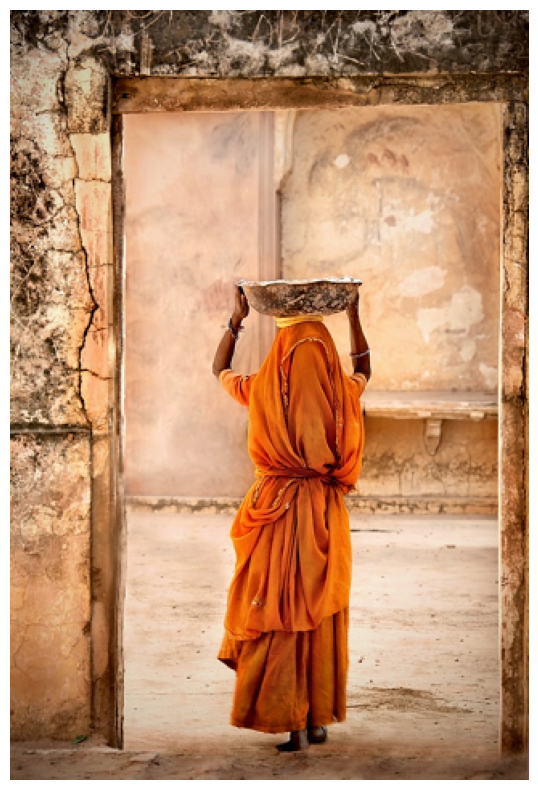

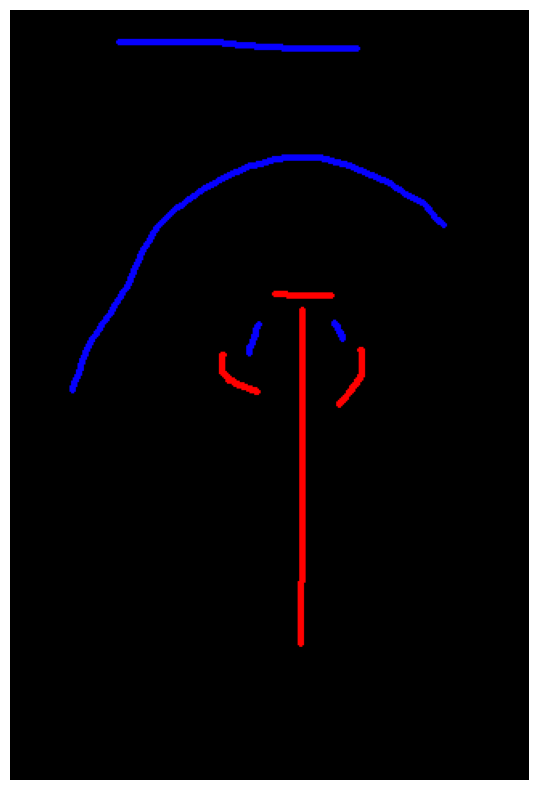

In [102]:
img = cv2.cvtColor(cv2.imread('./lady.PNG', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
mask = cv2.cvtColor(cv2.imread('./lady stroke 1.png', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
showImage(img, gray=False)
showImage(mask)

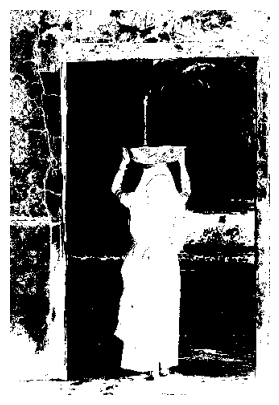

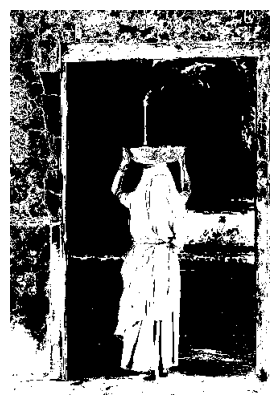

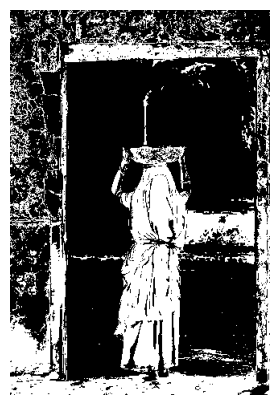

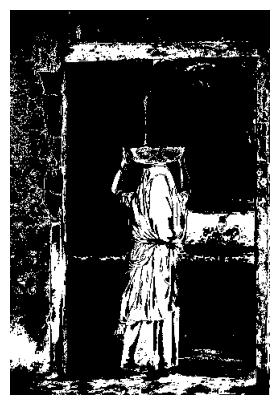

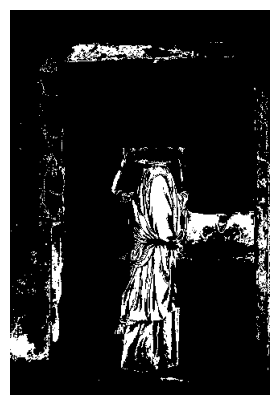

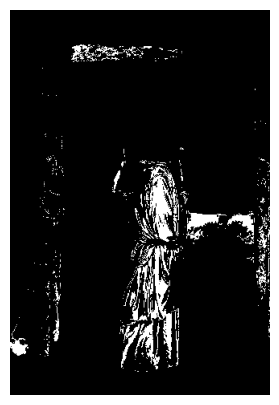

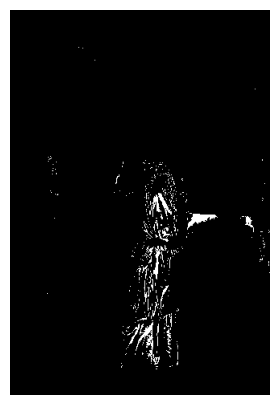

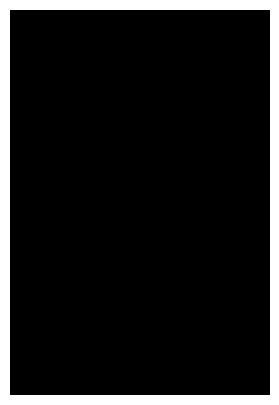

In [103]:
segmented = {}
for n in range(16, 129, 16):
    segmented[n] = segmentImage(img, mask, n)
    showImage(segmented[n], figsize=(5, 5))

### 🖌️ User Seed Segmentation 2

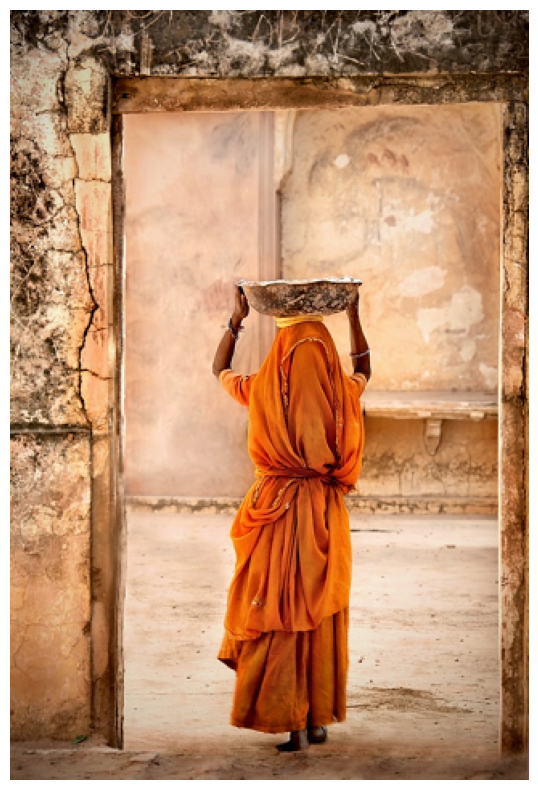

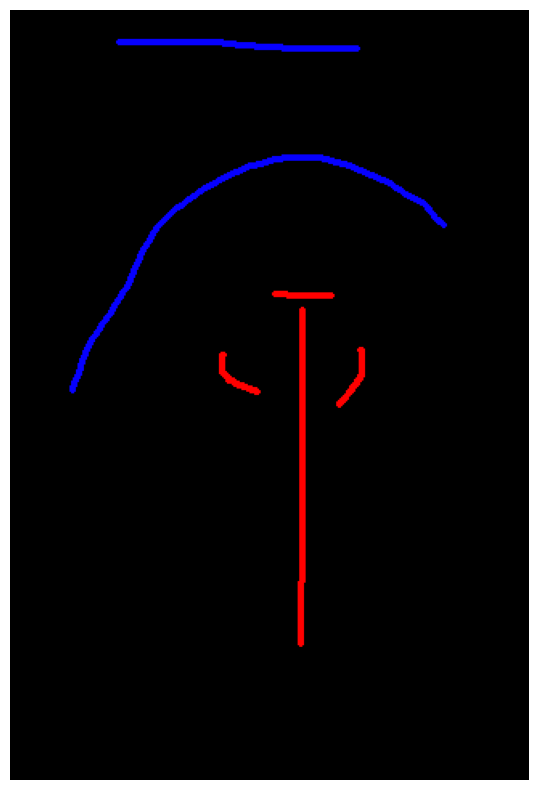

In [104]:
img = cv2.cvtColor(cv2.imread('./lady.PNG', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
mask = cv2.cvtColor(cv2.imread('./lady stroke 2.png', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
showImage(img, gray=False)
showImage(mask)

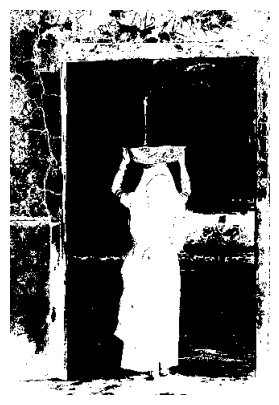

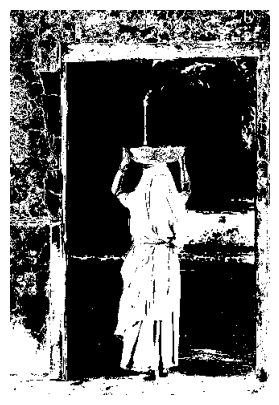

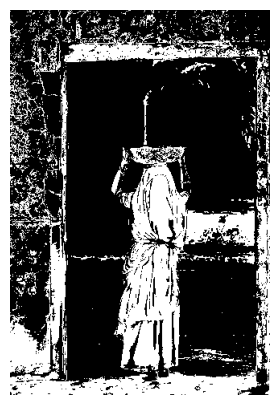

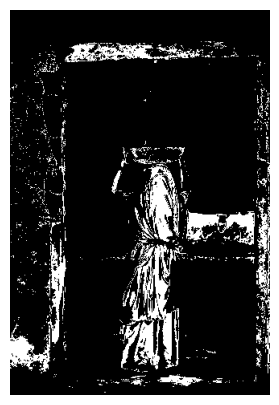

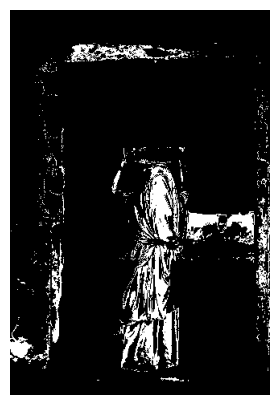

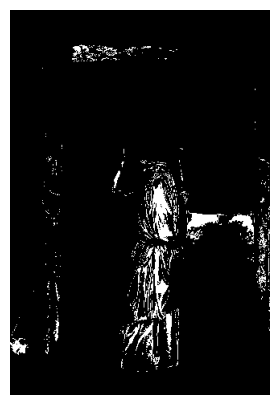

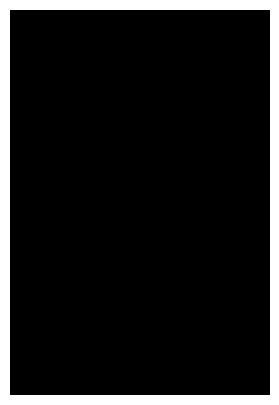

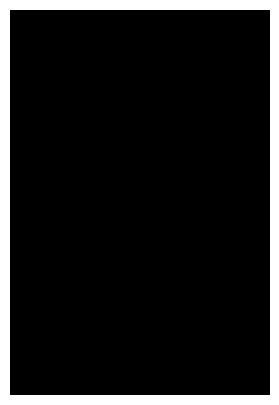

In [105]:
segmented = {}
for n in range(16, 129, 16):
    segmented[n] = segmentImage(img, mask, n)
    showImage(segmented[n], figsize=(5, 5))

## 🖼️ Test Case: Van Gogh

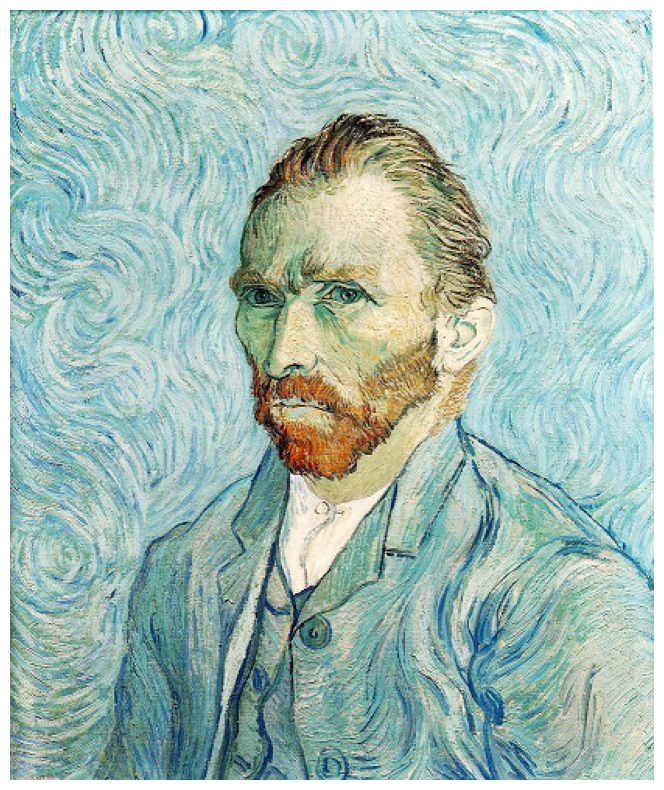

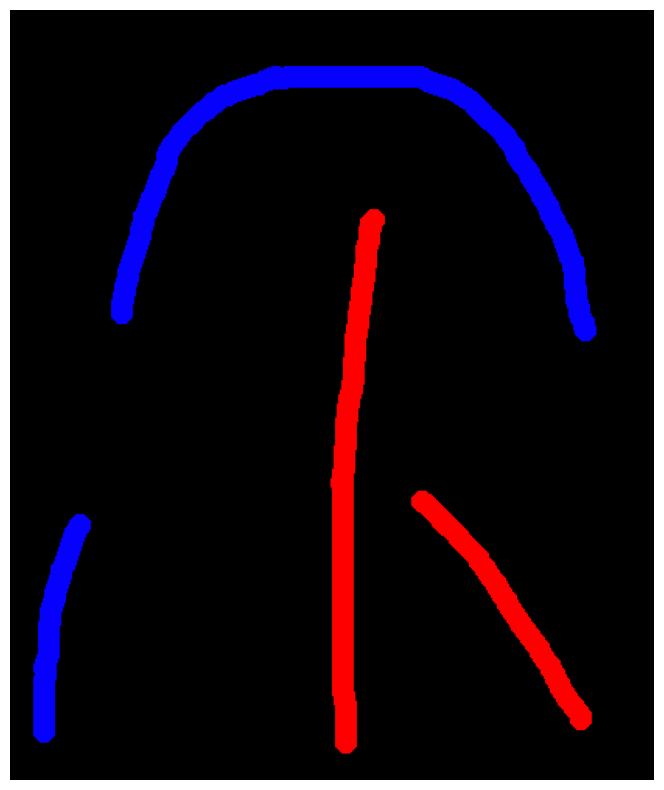

In [106]:
img = cv2.cvtColor(cv2.imread('./van Gogh.PNG', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
mask = cv2.cvtColor(cv2.imread('./van Gogh stroke.png', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
showImage(img, gray=False)
showImage(mask)

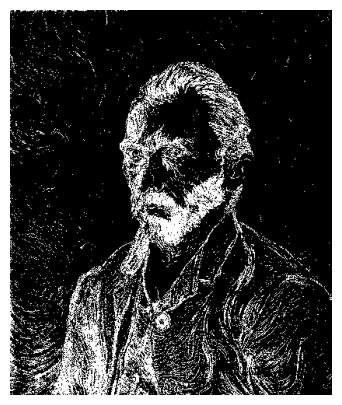

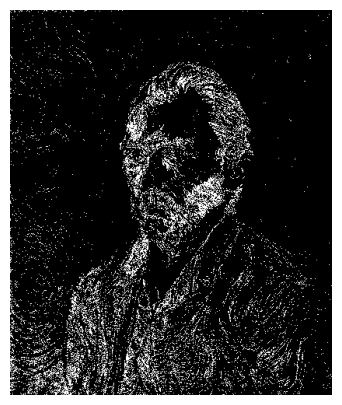

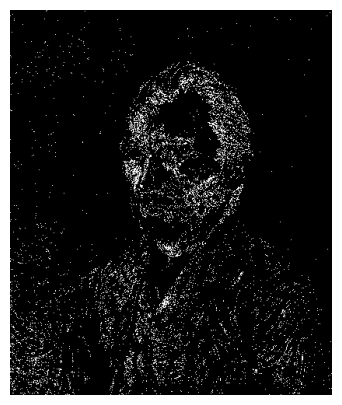

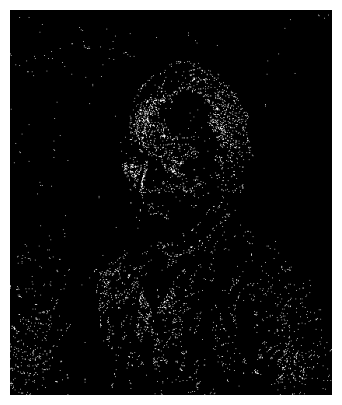

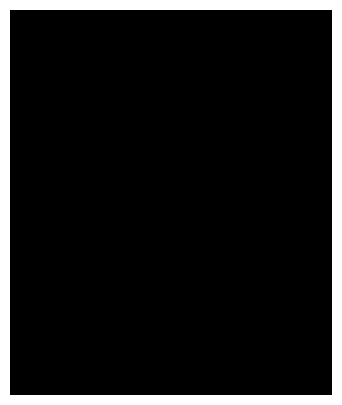

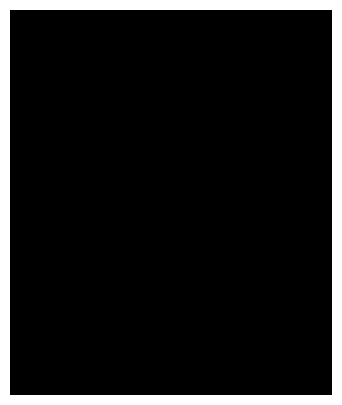

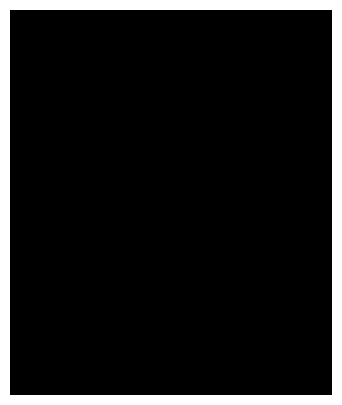

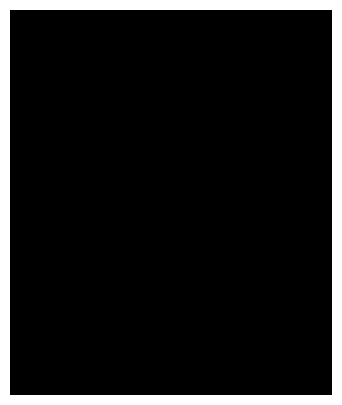

In [120]:
segmented = {}
for n in range(16, 129, 16):
    segmented[n] = segmentImage(img, mask, n)
    showImage(segmented[n], figsize=(5, 5))

## 🤗 Thank You